In [3]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 3.4 MB/s eta 0:00:22
    --------------------------------------- 1.0/72.0 MB 3.1 MB/s eta 0:00:23
   - -------------------------------------- 2.4/72.0 MB 3.6 MB/s eta 0:00:20
   - -------------------------------------- 3.4/72.0 MB 4.1 MB/s eta 0:00:17
   -- ------------------------------------- 4.5/72.0 MB 4.3 MB/s eta 0:00:16
   --- ------------------------------------ 5.8/72.0 MB 4.5 MB/s eta 0:00:15
   --- ------------------------------------ 6.8/72.0 MB 4.7 MB/s eta 0:00:14
   ---- ----------------------------------- 7.9/72.0 MB 4.7 MB/s eta 0:00:14
   ---- ----------------------------------- 8.7/72.0 MB 4.6 MB/s eta 0:00:14
   ----- ---------------------------------- 9.4/72.0 MB 4.5 MB/s eta 0:00:14
   ----- ---------------------------------- 10.2/72.0 MB 4.4 MB/s eta 0:00:15
   ------ --

Ma’lumotlar hajmi: (2000, 9)


C:\Users\klipm\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔥 AUC: 0.9705

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        65
           1       0.96      0.97      0.97       335

    accuracy                           0.94       400
   macro avg       0.90      0.88      0.89       400
weighted avg       0.94      0.94      0.94       400



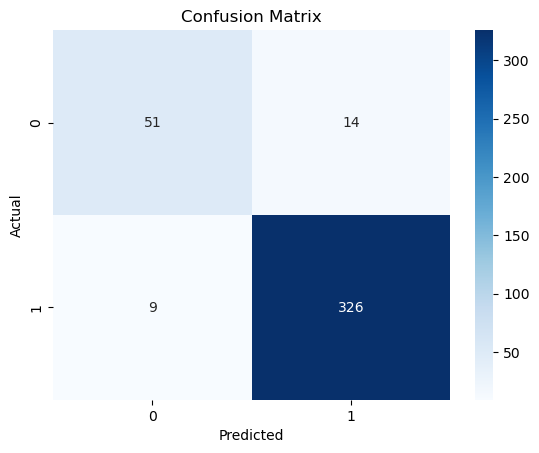

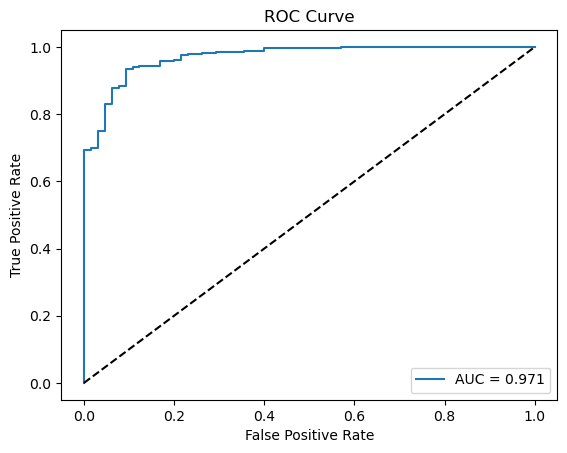

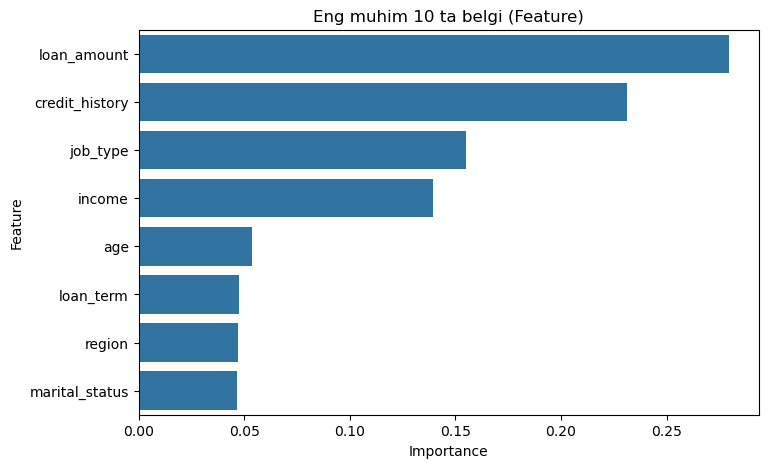


📊 Natijalar (birinchi 5 ta):
   Client_ID  Default_Probability
0          0             0.999722
1          1             0.999983
2          2             0.999479
3          3             0.998304
4          4             0.997822


In [5]:
# ===============================================================
# 1️⃣ Kutubxonalarni yuklash
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

from xgboost import XGBClassifier

# Tasodifiylikni nazorat qilish
np.random.seed(42)


# ===============================================================
# 2️⃣ Sun’iy kredit ma’lumotlarini yaratish
# ===============================================================
n = 2000  # mijozlar soni

data = pd.DataFrame({
    'age': np.random.randint(18, 65, n),
    'income': np.random.randint(500, 20000, n),
    'loan_amount': np.random.randint(1000, 30000, n),
    'loan_term': np.random.choice([6, 12, 24, 36, 48], n),
    'job_type': np.random.choice(['employee', 'self-employed', 'unemployed'], n),
    'marital_status': np.random.choice(['single', 'married', 'divorced'], n),
    'credit_history': np.random.choice(['good', 'average', 'bad'], n),
    'region': np.random.choice(['city', 'village'], n),
})

# Default ehtimolini sun’iy hosil qilamiz (model yaratish uchun “ground truth”)
data['default'] = (
    (data['loan_amount'] / (data['income'] + 1)) * 2 +
    (data['credit_history'] == 'bad').astype(int) * 1.5 +
    (data['job_type'] == 'unemployed').astype(int) * 1.2 +
    np.random.randn(n) * 0.5
) > 1.8
data['default'] = data['default'].astype(int)

print("Ma’lumotlar hajmi:", data.shape)
data.head()

# ===============================================================
# 3️⃣ Ma’lumotni tozalash
# ===============================================================
# Bo‘sh qiymatlar bo‘lsa to‘ldirish
data.fillna(data.median(numeric_only=True), inplace=True)

# Kategoriyali ustunlarni LabelEncoder bilan kodlash
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# ===============================================================
# 4️⃣ Train / Test bo‘lish
# ===============================================================
X = data.drop('default', axis=1)
y = data['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================================================
# 5️⃣ Scaling (normalizatsiya)
# ===============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ===============================================================
# 6️⃣ Modelni o‘qitish (XGBoost)
# ===============================================================
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# ===============================================================
# 7️⃣ Baholash
# ===============================================================
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
print("🔥 AUC:", round(auc, 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# 8️⃣ ROC egri chizig‘i
# ===============================================================
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ===============================================================
# 9️⃣ Eng muhim belgilarning ahamiyati (Feature Importance)
# ===============================================================
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title("Eng muhim 10 ta belgi (Feature)")
plt.show()

# ===============================================================
# 🔟 Har bir mijoz uchun “Default Probability” (score)
# ===============================================================
results = pd.DataFrame({
    'Client_ID': range(len(X_test)),
    'Default_Probability': y_pred_proba
})

print("\n📊 Natijalar (birinchi 5 ta):")
print(results.head())



In [7]:
results.to_csv("predicted_scores.csv", index=False)
print("\n✅ Fayl saqlandi: predicted_scores.csv")


✅ Fayl saqlandi: predicted_scores.csv
